In [1]:
#import scltnn
import scanpy as sc
import scvelo as scv
import anndata
import numpy as np

Global seed set to 0


In [2]:
import omicverse as ov
ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.9, Tutorials: https://omicverse.readthedocs.io/


In [3]:
from velovi import preprocess_data, VELOVI

In [4]:
adata=sc.read_h5ad('data/zebrafish.h5ad')
adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    layers: 'spliced', 'unspliced'

In [5]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 11388 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=50


/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # cell amount will influence the setting of n_neighbors

Filtered out 1582 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities


/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [14]:
scv.tl.recover_dynamics(adata,n_jobs=8)

recovering dynamics (using 8/12 cores)


  0%|          | 0/658 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:01:14) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [15]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [16]:
scv.tl.latent_time(adata)

computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [21]:
adata.obsm['X_umap']=adata.obs[['umap_1', 'umap_2']].values

In [22]:
adata.obsm['X_umap']

array([[0.10617525, 0.67937633],
       [1.26561804, 1.31584353],
       [0.22104474, 0.77730906],
       ...,
       [1.00687884, 0.98422336],
       [0.93685554, 1.08854284],
       [0.67368097, 1.57717771]])

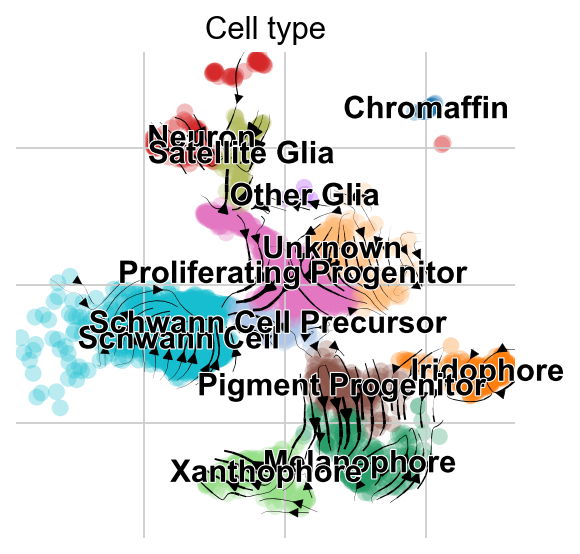

In [25]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='Cell_type')

In [33]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 392/500:  78%|███████▊  | 392/500 [01:29<00:24,  4.36it/s, loss=-2.07e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1984.035. Signaling Trainer to stop.


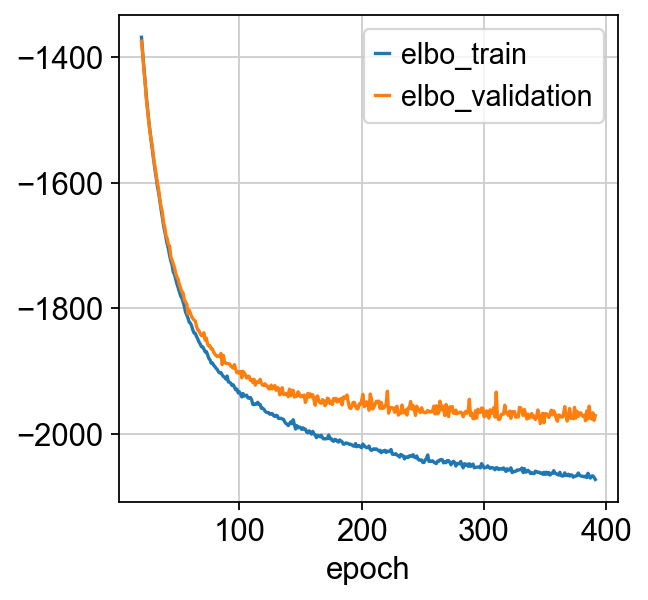

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

In [45]:
import torch
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [36]:
adata.obs['latent_time_raw']=adata.obs['latent_time'].copy()

In [46]:
likeli = vae.get_gene_likelihood(n_samples=10,)

In [ ]:
#adata.obs['latent_time_velovi']=vae.get_latent_time(n_samples=25,return_numpy=False).mean(axis=1).loc[adata.obs.index].values

In [47]:
vae.get_elbo()

tensor(2073.1501, device='cuda:0')

In [48]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/12 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


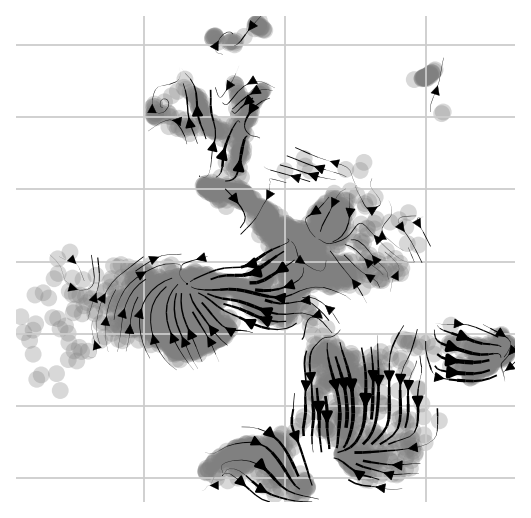

In [41]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [49]:
del adata.obs['root_cells']
scv.tl.latent_time(adata, min_likelihood=None)
#scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/omicverse/utils/_scatterplot.py:483: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(cax, orientation="vertical", cax=cax1)


[<AxesSubplot: title={'center': 'latent_time_raw'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <AxesSubplot: title={'center': 'latent_time'}, xlabel='X_umap1', ylabel='X_umap2'>]

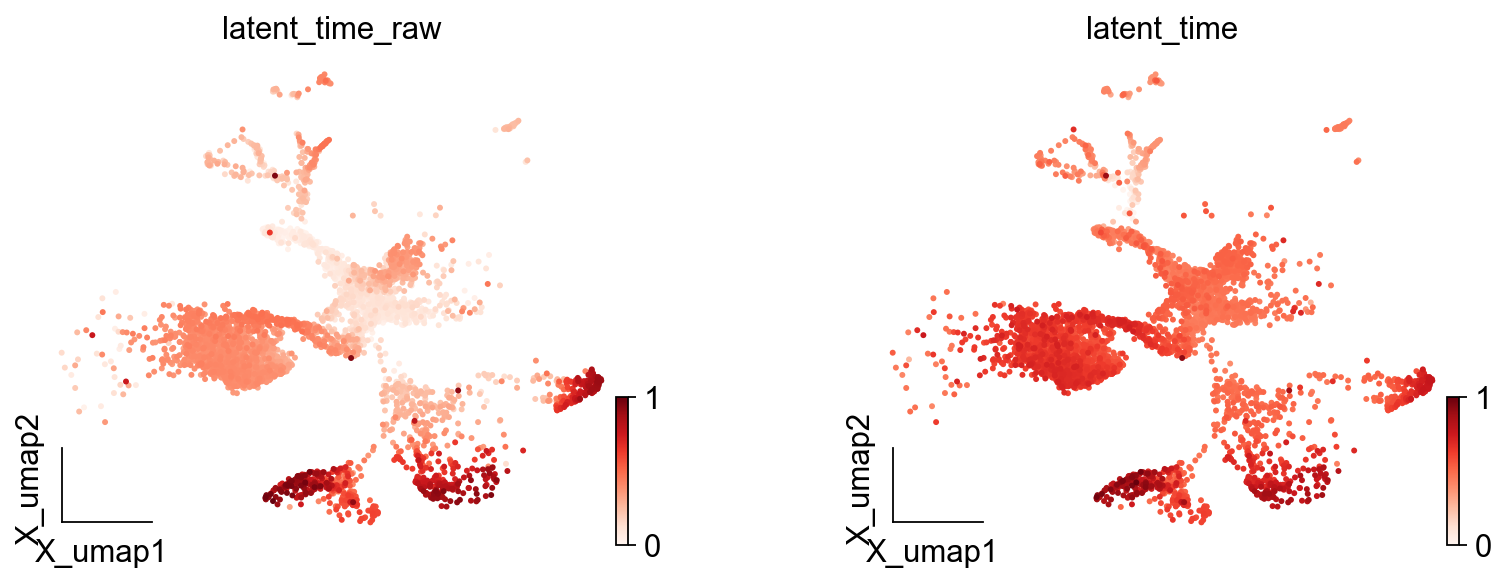

In [50]:
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(adata,basis='X_umap', color=['latent_time_raw','latent_time'], 
               cmap='Reds',legend_loc='right margin',frameon='small',
                   ncols=2,wspace=0.4,show=False,
                   #ax=ax
                  )

<AxesSubplot: title={'center': 'Cell_type'}, xlabel='X_umap1', ylabel='X_umap2'>

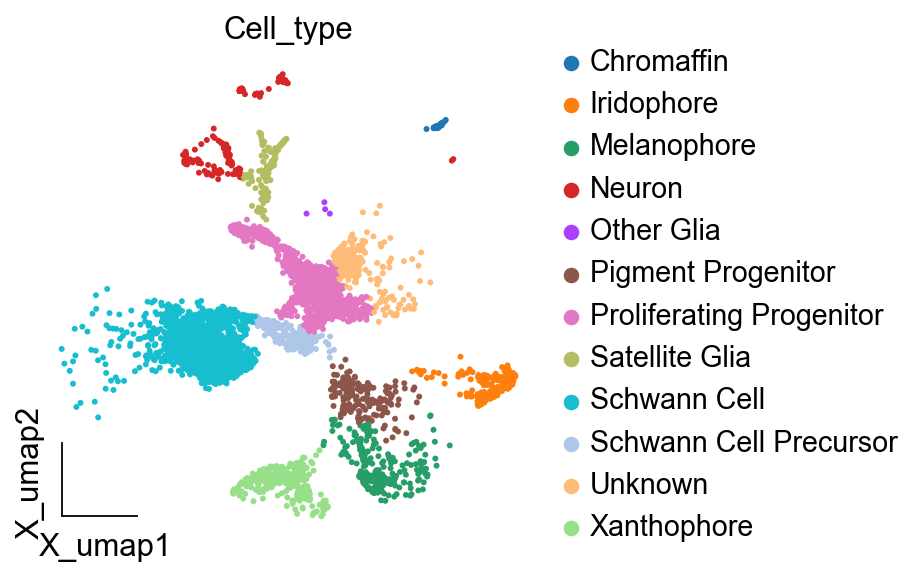

In [44]:
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(adata,basis='X_umap', color=['Cell_type'], 
               cmap='Reds',legend_loc='right margin',frameon='small',
                   ncols=2,wspace=0.4,show=False,
                   #ax=ax
                  )

In [51]:
import Epiverse as ev
ev.utils.lsi(adata, n_components=20, n_iter=15)

In [52]:
ltnn_obj=ov.single.scLTNN(adata,basis='X_lsi',input_dim=20,cpu='cuda:0')

In [55]:
adata.obs_names_make_unique()

In [56]:
ltnn_obj.ANNmodel_init(pseudotime='latent_time',batch_size=20,)
ltnn_obj.ANNmodel_train(n_epochs=200)

Pre-ANN model: 100%|██████████| 200/200 [00:34<00:00,  5.74it/s, val loss, val mae=0.00189, 0.00189]


In [57]:
ltnn_obj.ANNmodel_save('model/model_fish.h5')